# Evaluación de la clasificación con regresión logística

## Imports y configuraciones

In [2]:
import sys

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [5]:
sys.path.append('../src') # permite importar modulos de otros directorios
sys.path.append('../../../')
sys.path.append('../../../lab3/ej7/src/')

In [6]:
from lab3.ej7.src.arff_helper import DataSet
from lab3.ej7.src.ds_preprocessing import DataSetPreprocessor
from lab3.ej7.src.classifier import NBClassifier, KNNClassifier
from lab3.ej7.src.kfold import KFold
from classifier import LRClassifier

## Carga y preprocesamiento de los datasets
### Carga y preprocesamiento del dataset de entrenamiento
Utilizaremos el dataset de entrenamiento de la tercer entrega el cual contiene un 80% de las instancias del dataset completo tomadas al azar.

In [7]:
ds = DataSet()
ds.load_from_arff('../../../lab3/ej7/datasets/Autism-Adult-Training-Subset.arff')

Eliminamos la fila 305 (ver notebook cost_function_analysis.ipynb):

In [8]:
ds.pandas_df = ds.pandas_df.drop([305])\
    .reset_index()\
    .drop(columns=['index'])

Separamos la columna con el atributo objetivo y la guardamos en ```y```:

In [9]:
target_attribute = 'Class/ASD'
y = ds.pandas_df[target_attribute]

#### Transformación a atributos numéricos 

In [10]:
preprocessor = DataSetPreprocessor(ds, target_attribute)
df_numeric = preprocessor.transform_to_rn()\
    .drop(columns=target_attribute)
ds.pandas_df = ds.pandas_df.drop(columns=target_attribute)

### Carga y preprocesamiento del dataset de test
Utilizaremos el dataset de test de la tercer entrega el cual contiene el resto de las instancias o sea el 20% que no está en el dataset de entrenamiento.

In [11]:
ds_t = DataSet()
ds_t.load_from_arff('../../../lab3/ej7/datasets/Autism-Adult-Test-Subset.arff')

Separamos la columna con el atributo objetivo y la guardamos en ```y_t```:

In [12]:
y_t = ds_t.pandas_df[target_attribute]

#### Transformación a atributos numéricos 

In [13]:
preprocessor = DataSetPreprocessor(ds_t, target_attribute)
df_t_numeric = preprocessor.transform_to_rn()\
    .drop(columns=target_attribute)
ds_t.pandas_df = ds_t.pandas_df.drop(columns=target_attribute)

## Evaluación de la clasificación

La evaluaciones la haremos mediante cross-validation con 10 folds (k=10). Se realizan las particiones sobre el dataset de entrenamiento. En cada una de las 10 iteraciones se toman los índices de las instancias de test y training a partir de ese dataset y se obtienen las instancias correspondientes en el dataset con atributos numéricos.

In [15]:
def eval_algorithms(X_numeric, X_original, y, tolerances, metric_fn):
    
    # X_numeric: DataFrame
    # X_original: DataSet
    
    r = [[] for _ in range(len(tolerances) + 2)]
    kf = KFold(n_splits=10, do_shuffle=False)
    indexes = kf.split(X_original.pandas_df)
    le = LabelEncoder()
    
    for test_indexes, training_indexes in indexes:
        
        # Evaluacion del clasificador con Naive Bayes
        
        y_test = y.iloc[test_indexes]
        X_test = X_original.pandas_df.iloc[test_indexes]     
        y_train = y.iloc[training_indexes]
        X_train = X_original.pandas_df.iloc[training_indexes]
        
        clf = NBClassifier(target_attribute, X_original.attribute_info, X_original.attribute_list)
        clf.fit(X_train, y_train)
        y_predicted = clf.predict(X_test)
        
        r[0].append(metric_fn(y_test, y_predicted)) 
        
        # Evaluacion del clasificador con K Nearest Neighbours
        
        X_test = X_numeric.iloc[test_indexes]
        X_train = X_numeric.iloc[training_indexes]
        
        clf = KNNClassifier(7)
        clf.fit(X_train, y_train)   
        y_predicted = clf.predict(X_test)
        
        r[1].append(metric_fn(y_test, y_predicted)) 
        
        for (i, t) in enumerate(tolerances):

            y_test = le.fit_transform(y.iloc[test_indexes])
            X_test = X_numeric.iloc[test_indexes].as_matrix()
            y_train = le.fit_transform(y.iloc[training_indexes])
            X_train = X_numeric.iloc[training_indexes].as_matrix()

            clf = LRClassifier(t)
            clf.fit(X_train, y_train)
            y_predicted = clf.predict(X_test)
            
            r[i+2].append(metric_fn(y_test, y_predicted))
        
        print('[' + '>'*len(r[0]) + ' '*(10-len(r[0])) + ']', end='\r')

    return r

### Evaluación de accuracy

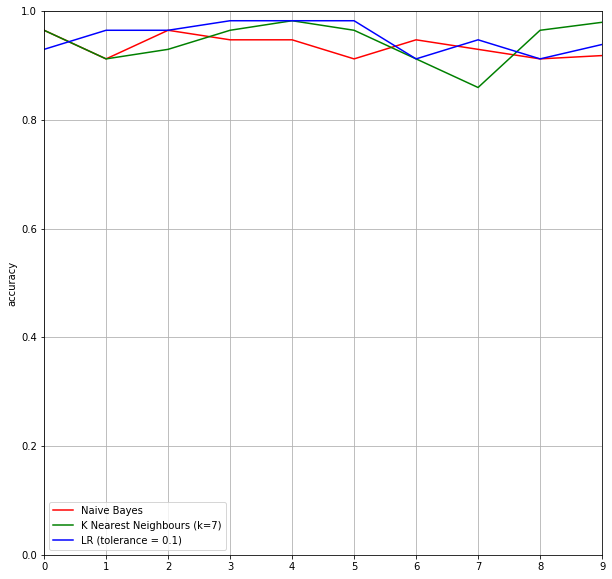

In [16]:
#tolerances = [0.1, 0.01]
tolerances = [0.1]
r = eval_algorithms(df_numeric, ds, y, tolerances, accuracy_score)
plt.figure(figsize=(10,10))
plt.ylabel('accuracy')
plt.axis([0, 9, 0, 1])
plt.grid(True)
plt.plot(r[0], color='r', label='Naive Bayes')
plt.plot(r[1], color='g', label='K Nearest Neighbours (K=7)')
plt.plot(r[2], color='b', label='LR (tolerance = {})'.format(tolerances[0]))
#plt.plot(r[3], color='c', label='LR (tolerance = {})'.format(tolerances[1]))
plt.legend(loc=0)
plt.show()

In [20]:
print('\nPromedio para Naive Bayes : {}'.format(np.mean(r[0])))
print('Promedio para K Nearest Neighbours (k=7) : {}'.format(np.mean(r[1])))
print('Promedio para Logistic Regression (tolerance=0.1) : {}\n'.format(np.mean(r[2])))


Promedio para Naive Bayes : 0.9356963838166846
Promedio para K Nearest Neighbours (k=7) : 0.9435732187611887
Promedio para Logistic Regression (tolerance=0.1) : 0.9517722878625132



### Evaluación de accuracy sobre el dataset de test

Aquí evaluaremos los tres algoritmos entrenando con el dataset de entrenamiento completo y evaluando en el dataset de test.

In [21]:
r = []

clf = KNNClassifier(7)
clf.fit(df_numeric, y)   
y_predicted = clf.predict(df_t_numeric)
r.append(accuracy_score(y_t, y_predicted))

clf = NBClassifier(target_attribute, ds.attribute_info, ds.attribute_list)
clf.fit(ds.pandas_df, y)
y_predicted = clf.predict(ds_t.pandas_df)
r.append(accuracy_score(y_t, y_predicted))

le = LabelEncoder()
clf = LRClassifier(0.1)
clf.fit(df_numeric.as_matrix(), le.fit_transform(y))
y_predicted = clf.predict(df_t_numeric.as_matrix())
r.append(accuracy_score(le.fit_transform(y_t), y_predicted))

print('\nK Nearest Neighbours (K=7): {}'.format(r[0]))
print('Naive Bayes : {}'.format(r[1]))
print('LR (tolerance = 0.1) : {}\n'.format(r[2]))


K Nearest Neighbours (K=7): 0.9148936170212766
Naive Bayes : 0.9290780141843972
LR (tolerance = 0.1) : 0.9716312056737588

